Import modules

In [24]:
from acf_core import get_srcmap_ero, tile_sky_map, hp, make_data_and_random_in_patch, calc_cf, set_mpl, ccl, def_cosmo, savepath
%matplotlib inline
nside = 4096

set palette to pastel
set matplotlib rc


Generate a population of AGN in `1<z<1.5` for `2e-15` limiting flux. Returns a Poisson-sampled healpix source map

/Users/sdbykov/work/forecast_clustering/notebooks/small_scale_clustering/../../scripts/forecast.py:1139: UserWarning: Using CCL Cell calculator with camb power spectrum
  warnings.warn(


Total AGN sources: 5740876 at fsky=1[41253 deg^2]
Photo-z parameters: self.sigma_0=0.03, self.f_fail=0.1


calc Covariance: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


observed density: 142.37307631055648
expected density: 139.16262360974824
0 src per pixel: 195571250, or 9.714e+01 per cent
1 src per pixel: 5639332, or 2.801e+00 per cent
2 src per pixel: 114078, or 5.666e-02 per cent
3 src per pixel: 1905, or 9.462e-04 per cent


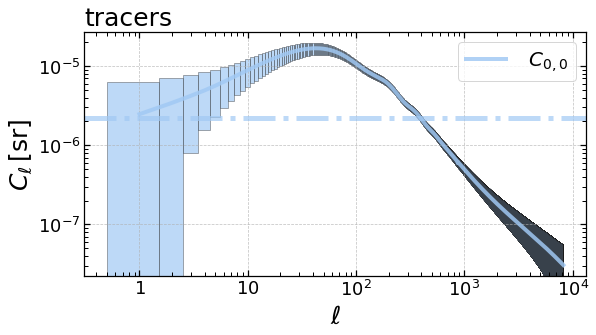

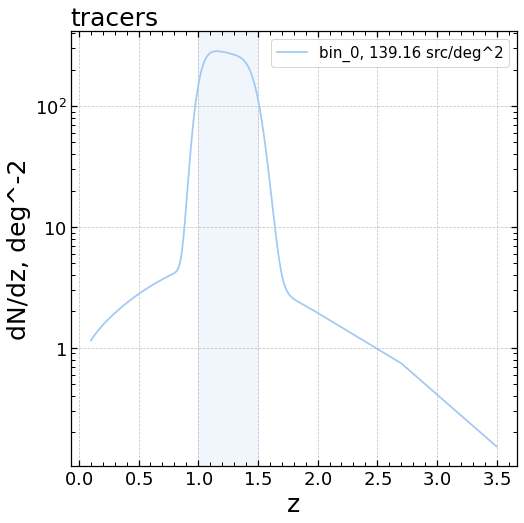

<Figure size 432x288 with 0 Axes>

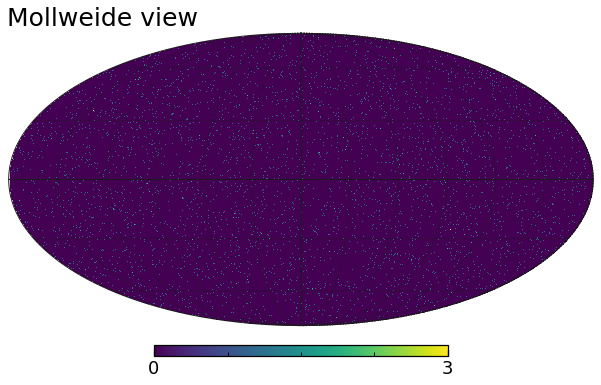

In [5]:
cell, dens, datagen, pois = get_srcmap_ero(slim=2e-15,
                            zmin=1,
                            zmax = 1.5,
                            sigma_0=0.03,
                            f_fail=0.1,
                            nside=nside,)

Generate lots of `5x4` deg masks.

In [7]:
totmask, masks, borders_dicts, pixels_patches = tile_sky_map(nside, 5, 4 , 100)

 71%|███████▏  | 20/28 [03:13<01:17,  9.67s/it]

101 patches


101


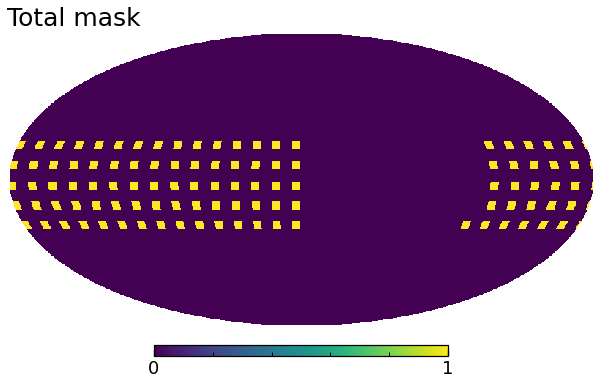

In [9]:
hp.mollview(totmask, title='Total mask')
print(len(masks))

Define the properties of angular correlation function (ACF) and compute it for one of the tiles

In [10]:
min_sep=3e-2
max_sep=1 
bin_size=0.5


<Figure size 432x288 with 0 Axes>

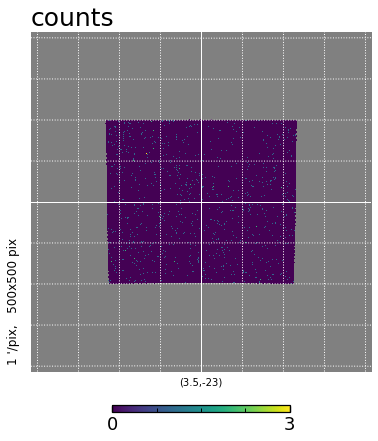

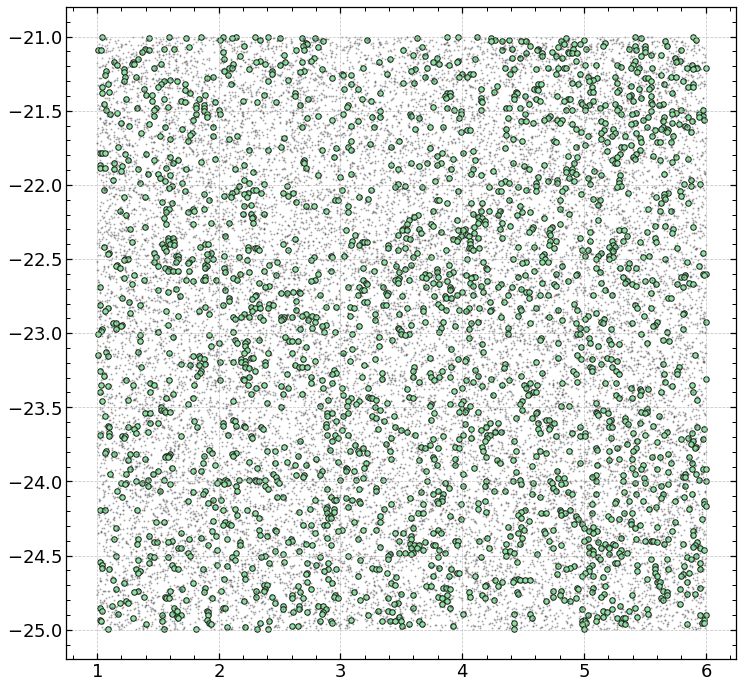

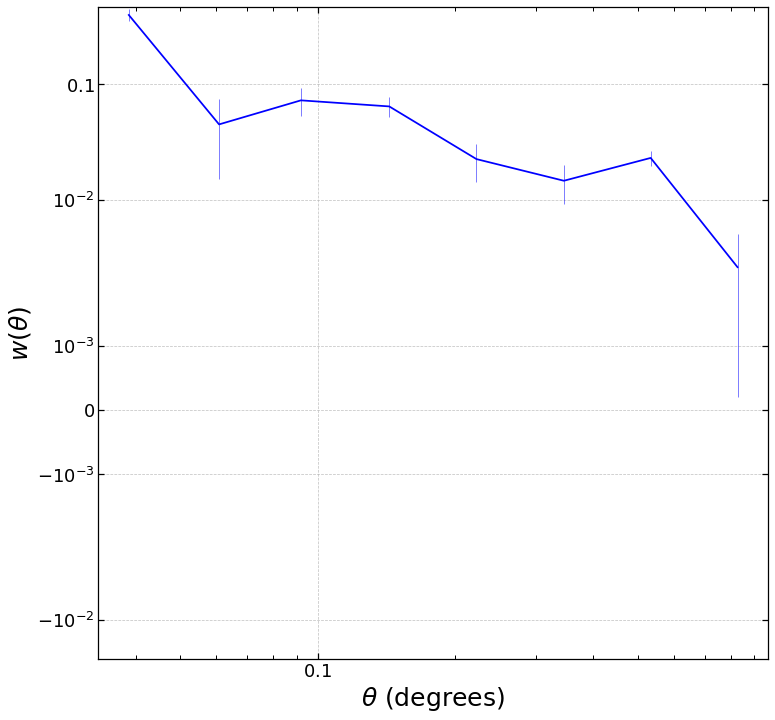

In [13]:
xis, sigs = [], []
cat, cat_rand, mask = make_data_and_random_in_patch(pois,
masks[0], borders_dicts[0], pixels_patches[0], plot = True)
r, xi, sig,  dd = calc_cf(cat, cat_rand, min_sep=min_sep, max_sep=max_sep, bin_size=bin_size, plot = True)
xis.append(xi)
sigs.append(sig)

Iterate over all tiles and save the corresponding ACFs

In [14]:


for ii in range(1, len(masks)):
    cat, cat_rand, mask = make_data_and_random_in_patch(pois,
    masks[ii], borders_dicts[ii], pixels_patches[ii], plot = False)
    r, xi, sig,  dd = calc_cf(cat, cat_rand, min_sep=min_sep, max_sep=max_sep, bin_size=bin_size, plot = False)
    xis.append(xi)
    sigs.append(sig)

Plot the results of the simulation and the input ACF

set palette to pastel
set matplotlib rc


Text(0, 0.5, '$w(\\theta)$')

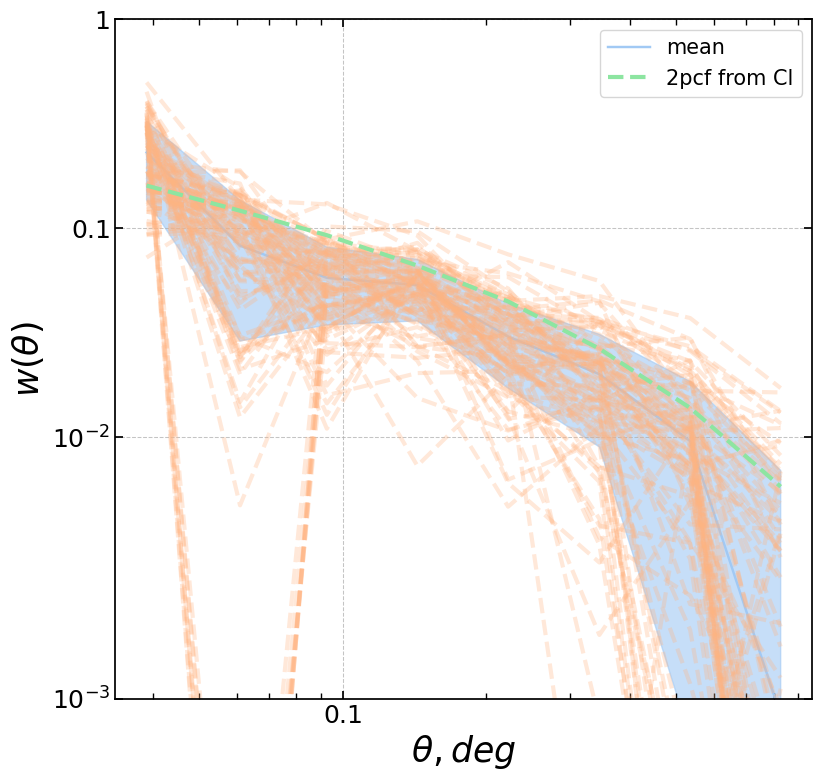

In [21]:
set_mpl()
plt.figure(figsize=(9,9))

mean_xi = np.mean(xis, axis=0)
std_xi = np.std(xis, axis=0)

plt.plot(r, mean_xi, 'C0-',label='mean')
plt.fill_between(r, mean_xi-std_xi, mean_xi+std_xi, color='C0', alpha=0.6)
for jj, (xi, sig) in enumerate(zip(xis, sigs)):
    plt.plot(r, xi,  'C1--', lw = 3, alpha = 0.3)
    #plt.fill_between(r, xi-sig, xi+sig, alpha=0.05)



ccl_res = ccl.correlation(def_cosmo, datagen.ell_rebin, datagen.cls_rebin[0],theta = r, type = 'NN', method='fftlog', ) # Legendre or fftlog or Bessel
plt.plot(r, ccl_res, 'C2--', lw =3, label = '2pcf from Cl')

plt.xscale('log')
plt.yscale('symlog', linthresh=2e-3)
plt.ylim(1e-3,1)
plt.legend()
plt.xlabel('$\\theta, deg$')
plt.ylabel('$w(\\theta)$')

#hpresol = np.rad2deg(hp.nside2resol(nside, arcmin=False))
#plt.axvline(hpresol, color='k', ls='--', lw=2, label='$\\Delta\\theta = %.2f$'%hpresol)

Save the data in an appropriate format 

4.7016952855735985
5.768678183397685


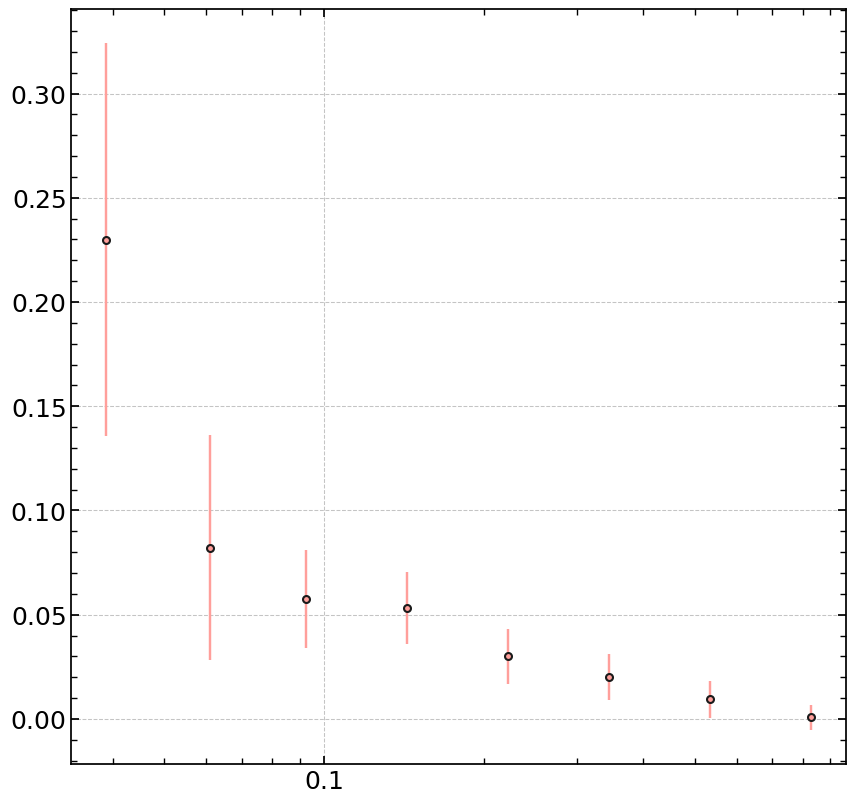

In [22]:
data_arr = np.array(xis).mean(axis = 0)
cov = np.cov(np.array(xis).T)
icov = np.linalg.pinv(cov)

plt.errorbar(r, data_arr, yerr=np.sqrt(np.diag(cov)), fmt='C3.', label='$\\xi$')
plt.xscale('log')
snr = np.sqrt(np.einsum('i,ji, j->', data_arr, icov, data_arr))
print(snr)

snr_naive = np.sqrt(np.sum(data_arr**2/np.diag(cov)))
print(snr_naive)

np.savez(savepath+'/LH_xi', r=r, xi=data_arr, cov=cov, ccl_res=ccl_res)